<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/spatial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatial Analysis: Text Classification, Clustering, and Regression

* Using a collection of proverbs from the [Hellenic Folklore Research Centre](http://www.kentrolaografias.gr/) of the Academy of Athens.
* Using [Folium](https://pypi.org/project/folium/), [Geopy](https://geopy.readthedocs.io/en/stable/), and [scikit-learn](https://scikit-learn.org/stable/) algorithms for hierarchical clustering, classification and regression.

---


In [1]:
%%capture
!pip install geopandas
!pip install geopy
!pip install folium
!pip install gdown
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from tqdm.notebook import tqdm
from folium import Choropleth, Circle, CircleMarker, Marker
from folium.plugins import MarkerCluster
from collections import Counter
import nltk; nltk.download('stopwords')
import matplotlib.pyplot as plt

## Loading the data

In [2]:
proverbs = pd.read_csv("https://raw.githubusercontent.com/ipavlopoulos/paremia/main/input/proverbs.csv", index_col=0)
proverbs.shape

(134493, 4)

In [3]:
proverbs.sample(3)

,text,place,uri,collector
40693,Νά λείψουν τά πιπέρια μού νά δώ τις μαγειριές σου,Χίος,http://hdl.handle.net/20.500.11853/276764,"Κανελλάκης, Κωνσταντίνος Μ."
4939,Κοντός ψαλμός αλληλούϊα,"Θράκη, Σαράντα Εκκλησίες",http://hdl.handle.net/20.500.11853/204783,"Βαφείδης, Θεολόγης Γ."
115714,Η σκύλα πε τη βιά της στραβά κάμνει τα παιδιά της,"Μικρά Ασία, Κύζικος, Αρτάκη",http://hdl.handle.net/20.500.11853/159092,"Φιλανθίδης, Μενέλαος Π."


* Few proverbs comrpise definitions, removing them

In [4]:
proverbs[proverbs.text.str.contains("=")].sample().text.item()

'Αγγελομαχώ = ψυχομαχώ, ψυχορραγώ'

In [5]:
proverbs = proverbs[~proverbs.text.str.contains("=")]
proverbs.shape

(134106, 4)

* Also, duplicates exist.

In [6]:
proverbs[proverbs.duplicated()]

,text,place,uri,collector
62809,Απού δε θέλει χτύπους στο χαρκιδιό δεν πάει,"Κρήτη, Αποκόρωνας, Μελιδόνι",http://hdl.handle.net/20.500.11853/161130,"Λιουδάκη, Μαρία"
62810,"Απού δε σπείρη τον Οχτώβρη, οχτώ σωρούς δεν κάνει","Κρήτη, Λασίθι, Τζερμιάδο",http://hdl.handle.net/20.500.11853/288692,"Λιουδάκη, Μαρία"
62811,"Απού διαλέει, πάει ποδιαλεμάτου","Κρήτη, Λασίθι, Άγιος Γεώργιος",http://hdl.handle.net/20.500.11853/163118,"Λιουδάκη, Μαρία"
62812,Απού δουλεύγει βασιλιά το νού ντου πρέπει νάχη...,"Κρήτη, Ρέθυμνο",http://hdl.handle.net/20.500.11853/151409,"Λιουδάκη, Μαρία"
62813,Απού ζυμώση και πλυθή σαράντα μέρες είν' καλή,"Κρήτη, Λασίθι, Άγιος Γεώργιος",http://hdl.handle.net/20.500.11853/163084,"Λιουδάκη, Μαρία"
...,...,...,...,...
134488,Απ' ούλα τα φαΓια το ρύζ' και τσόχα να φορής,"Θράκη, Σαμακόβι",http://hdl.handle.net/20.500.11853/245653,anonymous
134489,Απ' τ' Άη – Λιός και μπρός γυρίζει ο καιρός αλ...,"Μεσσηνία, Φιλιατρά",http://hdl.handle.net/20.500.11853/160335,anonymous
134490,Απ' τ' Άι – Ηλιά το βράδυ βάζει η ελιά το λάδι,Σίφνος,http://hdl.handle.net/20.500.11853/190853,anonymous
134491,Απ' τ' άλουγου στου γουμάρι,Ήπειρος,http://hdl.handle.net/20.500.11853/159862,anonymous


* There are more duplicates when considering the `text` column only.

In [25]:
num_total_duplicates = proverbs.text.duplicated().sum()
num_total_duplicates

24836

* Climbing up to the highest-level information per location labelled.

* In 'Κέρκυρα, Οθωνοί', for example, we only keep the first part of the term, using `split` to tokenise.

In [8]:
proverbs["area"] = proverbs.place.map(lambda x: x.split(",")[0])
proverbs.sample(3)

,text,place,uri,collector,area
21590,Έχω γω ράμματα για τη γούνα σου,Αμοργός,http://hdl.handle.net/20.500.11853/251846,"Ιωαννίδης, Εμμανουήλ",Αμοργός
3428,Η καρδιά κι βαστά,Πόντος,http://hdl.handle.net/20.500.11853/269413,"Βαλαβάνης, Ι.",Πόντος
35765,"Τηγάνι εδανειζόμαστε, ξυλά ήθελ΄ αν τα βρούμε,...",Επτάνησος,http://hdl.handle.net/20.500.11853/174050,"Καββαδίας, Γεώργιος",Επτάνησος


* One more observation regards proverbs with no information about their location 


In [9]:
len(proverbs[proverbs.area=='Άδηλου τόπου'].text.unique())

3698

# Geolocating

* There are 134 unique broad areas registered in the collection

In [10]:
locations = proverbs.area.unique()
len(locations)

134

* We will find the geographical coordinates of each one.

* Using [geopy](https://geopy.readthedocs.io/en/stable/#), which is a Python client for geocoding web services, locating the coordinates (e.g., of addresses, cities, countries) across the globe.

* This is already done and saved, but you can repeat this step by geocoding each location in the dataframe with the following code. Adding the country's name in the query improves the accuracy, but geolocation still doesn't work for all places. Hence, some are printed and fixed by hand.  

In [24]:
#@title [optional] Geocoding
import os

if not os.path.exists('geolocs.csv'):
    from geopy.geocoders import Nominatim # import the library
    geolocator = Nominatim(user_agent="paremia") # initialise it

    geolocs = {}
    for loc in locations:
        # Avoiding polysemy by including "Greece" in the query
        location = geolocator.geocode(loc+ ", Ελλάδα") 
        if location:
            geolocs[loc] = {"lat":location.latitude, "lon":location.longitude}
        else:
            print (loc)

    # fixing some by hand (Cyprus was mislocated too)
    location = geolocator.geocode("Cyprus")
    geolocs["Κύπρος"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Siteia")
    geolocs["Ανατολική Κρήτη"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Chania")
    geolocs["Δυτική Κρήτη"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Nafpaktia")
    geolocs["Ναυπακτία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Lepenou")
    geolocs["Λεπενού Αιτωλοακαρνανίας (επαρχία Βάλτου)"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Cappadocia")
    geolocs["Καππαδοκία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Imathia")
    geolocs["Ημαθία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Boeotia")
    geolocs["Βοιωτία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Edirne")
    geolocs["Ανατολική Θράκη"] = {"lat":location.latitude, "lon":location.longitude}
    geolocs["Αδριανούπολη"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Phthiotis")
    geolocs["Φθιώτιδα"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Andritsaina")
    geolocs["Ανδρίτσαινα Ολυμπίου"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Dardanelles Strait")
    geolocs["Δαρδανέλλια (Ελλήσποντος)"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Central Greece")
    geolocs["Στερεά Ελλάδα"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Areopoli")
    geolocs["Αερόπολη"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Trifylia")
    geolocs["Τριφυλία"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("Phocis")
    geolocs["Φωκίδα"] = {"lat":location.latitude, "lon":location.longitude}
    location = geolocator.geocode("West Mani")
    geolocs["Δυτική Μάνη"] = {"lat":location.latitude, "lon":location.longitude}

    pd.DataFrame(geolocs).to_csv("geolocs.csv", index=False)

In [14]:
geolocs = pd.read_csv("https://raw.githubusercontent.com/ipavlopoulos/paremia/main/input/geolocs.csv") 
geolocs.index=["lat", "lon"]
geolocs

,Κρήτη,Σίφνος,Σέρρες,Πήλιο,Ήπειρος,Λευκάδα,Αχαΐα,Εύβοια,Μακεδονία,Κύπρος,...,Ανατολική Θράκη,Αδριανούπολη,Φθιώτιδα,Ανδρίτσαινα Ολυμπίου,Δαρδανέλλια (Ελλήσποντος),Στερεά Ελλάδα,Αερόπολη,Τριφυλία,Φωκίδα,Δυτική Μάνη
lat,35.308495,36.971401,41.091071,39.365088,37.998253,38.706573,38.069275,38.494172,40.686024,34.982302,...,41.675933,41.675933,38.88734,37.483836,40.337606,38.562460,36.665918,37.195013,38.499868,22.581762
lon,24.463342,24.708110,23.549803,23.135561,23.737867,20.641709,21.872730,23.911084,23.693434,33.145128,...,26.558722,26.558722,22.36803,21.905533,26.640821,23.161853,22.381635,21.703732,22.248780,88.399181


In [15]:
# turning it into a dict, our initial selection
geolocs = geolocs.to_dict()

* Now, updating the corpus with the mined information

In [16]:
proverbs['lat'] = proverbs.area.map(lambda x: geolocs[x]["lat"] if x in geolocs else None)
proverbs['lon'] = proverbs.area.map(lambda x: geolocs[x]["lon"] if x in geolocs else None)
proverbs[proverbs.lon.notna()].shape

(125222, 7)

# The anonymous collector
* Not all proverbs were collected by named individuals.

In [17]:
anonymous = proverbs[proverbs.collector=="anonymous"]
named = proverbs[proverbs.collector!="anonymous"]
print(f'{anonymous.shape[0]} proverbs from the anonymous collectors')

14835 proverbs from the anonymous collectors


# Duplicates

* Focusing on proverbs shared among locations.

* Using ones by named collectors.

* While the areas of the duplicates collected by anonymous individuals are not many.

In [44]:
num_named_duplicates = named.text.duplicated().sum()
num_anonymous_duplicates = anonymous.text.duplicated().sum()
num_sum_duplicates = num_named_duplicates + num_anonymous_duplicates
num_total_duplicates = proverbs.text.duplicated().sum()
print(f'Only {num_named_duplicates} duplicate proverbs from named collectors')
print(f'while {num_anonymous_duplicates} are from the anonymous collector')
print(f'Sum is {num_sum_duplicates} out of {num_total_duplicates} total duplicates')
print(f'Diff is {num_total_duplicates - num_sum_duplicates}')

Only 10861 duplicate proverbs from named collectors
while 13868 are from the anonymous collector
Sum is 24729 out of 24836 total duplicates
Diff is 107


* The difference above between the total duplicates and the sum of the named and the anonymous duplicates is explained by the existence of duplicates between named and anonymous.

In [45]:
pd.merge(named, anonymous, how='inner', on='text').text.unique().shape

(107,)

* The duplicates from the named collectors concern 134 locations.

In [46]:
named[named.text.duplicated()].area.unique()

array(['Εύβοια', 'Λέσβος', 'Ήπειρος', 'Ρούμελη', 'Κοζάνη', 'Αρκαδία',
       'Ίμβρος', 'Φιλιππούπολη', 'Αττική', 'Πόντος',
       'Δαρδανέλλια (Ελλήσποντος)', 'Θράκη', 'Μακεδονία', 'Κεφαλληνία',
       'Μήλος', 'Χίος', 'Μικρά Ασία', 'Κρήτη', 'Κίμωλος', 'Άνδρος',
       'Λέρος', 'Ρόδος', 'Κύπρος', 'Άρτα', 'Πρέβεζα', 'Παξοί', 'Καρδίτσα',
       'Άδηλου τόπου', 'Καστελλόριζο (Μεγίστη)', 'Αθήνα', 'Μεσσηνία',
       'Λακωνία', 'Σίφνος', 'Ηλεία', 'Σύμη', 'Θήρα (Σαντορίνη)', 'Κως',
       'Σμύρνη', 'Κάλυμνος', 'Νάξος', 'Αδριανούπολη', 'Ευρυτανία',
       'Κέρκυρα', 'Αμοργός', 'Θεσπρωτία', 'Σάμος', 'Καστοριά', 'Βοιωτία',
       'Επτάνησος', 'Νίσυρος', 'Αχαΐα', 'Κορινθία', 'Τήλος', 'Πέλλα',
       'Λάρισα', 'Κύθηρα', 'Ιωάννινα', 'Ημαθία', 'Φωκίδα', 'Πελοπόννησος',
       'Σύρος', 'Μάνη', 'Σκύρος', 'Αιτωλία', 'Κύθνος', 'Τήνος', 'Κέα',
       'Άγιον Όρος', 'Πάρος', 'Θεσσαλία', 'Μάλγαρα', 'Ανατολική Κρήτη',
       'Μαγνησία', 'Σέριφος', 'Ιθάκη', 'Λευκάδα', 'Αργολίδα',
       'Καππαδοκία', 'Ακαρναν

* We group by text the `named` duplicates , to get duplicates using items by named collectors.

In [47]:
grouping = named[named.lat.notna() & named.lon.notna()].groupby("text")
duplicates = pd.DataFrame({"place": grouping.place.apply(set)})
duplicates["place_num"] = duplicates.place.apply(len)
duplicates.sort_values(by="place_num", ascending=False)[:3]

,place,place_num
text,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Μικρά Ασία, Βουρλά, Θεσπρωτία, Παραμυθιά, Θεσ...",45
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Θράκη, Σουφλί, Θράκη, Σηλυβρία, Θράκη, Αυδήμι...",28
Θεωρία επισκόπου και καρδιά μυλωνά,"{Μακεδονία, Θράκη, Σαράντα Εκκλησίες, Φιλιππού...",27


* Finding the broader location, which we'll call `area`.

In [48]:
duplicates["area"] = duplicates.place.map(lambda x: {i.split(",")[0] for i in x})
duplicates["area_num"] = duplicates.area.apply(len)
duplicates.sort_values(by="area_num", ascending=False)[:3]

,place,place_num,area,area_num
text,,,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Μικρά Ασία, Βουρλά, Θεσπρωτία, Παραμυθιά, Θεσ...",45,"{Ημαθία, Ικαρία, Αργολίδα, Νάξος, Φιλιππούπολη...",23
Στου κουφού την πόρτα όσο θέλεις βρόντα,"{Θεσπρωτία, Παραμυθιά, Θράκη, Σουφλί, Ικαρία, ...",26,"{Ικαρία, Νάξος, Φιλιππούπολη, Κεφαλληνία, Ιωάν...",20
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Θράκη, Σουφλί, Θράκη, Σηλυβρία, Θράκη, Αυδήμι...",28,"{Αρκαδία, Αδριανούπολη, Μακεδονία, Δαρδανέλλια...",18


In [49]:
print(f"Out of the {duplicates.shape[0]} unique texts,", 
      f"{duplicates[duplicates.area_num>1].shape[0]} exist in multiple areas")

Out of the 105612 unique texts, 3204 exist in multiple areas


* We'll focus on proverbs common across `area`s.

In [50]:
duplicates = duplicates[duplicates.area_num>1]

* We add the geographical coordinates in the duplicates.

* We want a list per proverb, given that there is an 1:n mapping between proverbs and areas.

In [52]:
coordinates = duplicates.area.map(lambda x: [(geolocs[loc]["lat"], geolocs[loc]["lon"]) 
                                             for loc in x if loc in geolocs and loc!="Άδηλου τόπου"])
duplicates.insert(4, 'latlon', coordinates) 
duplicates.sample()

,place,place_num,area,area_num,latlon
text,,,,,
Έχει ο σκύλος μας αφέντη κι ο αφέντης παραφέντη,"{Βόρειος Ήπειρος, Ιωάννινα, Νεγάδες}",2,"{Ιωάννινα, Βόρειος Ήπειρος}",2,"[(39.6639818, 20.8522784), (39.49035545, 20.25..."


In [53]:
# saving
duplicates.to_pickle("duplicates_geolocated.csv")

* Let's visualising the dataframe.

* We will use [Folium](https://python-visualization.github.io/folium), which is based on [leaflet](https://leafletjs.com/), an open-source JavaScript library for mobile-friendly interactive maps. 

* Note that outliers exist: Chiesa della Madona delle Neve

In [32]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=6)

for i in range(duplicates.shape[0]):
    loc = duplicates.iloc[i].latlon
    folium.PolyLine(loc, color='red', weight=1, opacity=0.1).add_to(m)

m.save("duplicates.html")
m

* Let's find the number of areas sharing proverbs with crowdy Athens

In [54]:
area = 'Αθήνα'
print(f"Branching factor of {area}: {len(duplicates[duplicates.area.apply(lambda x: 'Αθήνα' in x)].area.explode().unique())}")

Branching factor of Αθήνα: 20


# Single-placed proverbs

In [55]:
# keeping single-placed proverbs
proverbs_sp = named[~named.text.duplicated(keep=False)]
print(proverbs_sp.shape[0])
proverbs_sp.sample(3)

100879


,text,place,uri,collector,area,lat,lon
118072,Κόρωσαν οι ποδιές τς',"Θράκη, Πετροχώρι Μετρών",http://hdl.handle.net/20.500.11853/246630,"Χουρμουζιάδης, Κ.",Θράκη,40.846424,25.875938
39285,Με τα κόκκινα πανάκια τα γελούνε τα παιδάκια,"Αρκαδία, Γορτυνία",http://hdl.handle.net/20.500.11853/171022,"Κανδηλώρος, Τάκης Χ.",Αρκαδία,38.036858,23.668926
45280,Όσου αριών΄ν τα σκόρδα τόσου προυκόβ'ν,"Ήπειρος, Δολιανά",http://hdl.handle.net/20.500.11853/148639,"Κοντοπάνος, Α.",Ήπειρος,37.998253,23.737867


* We'll move aside single-placed proberbs from an unknown place.

In [57]:
unlocated = "Άδηλου τόπου"
proverbs_sp_unk = proverbs_sp[proverbs_sp.place==unlocated]
print(f'{proverbs_sp_unk.shape[0]} proverbs from one place, whose name is not known.')
proverbs_sp_unk.sample(3)

2755 proverbs from one place, whose name is not known.


,text,place,uri,collector,area,lat,lon
102622,Ο πουνέντης κι ο γαρμπής να βραδυάση και να ιδής,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/194808,"Πολίτης, Ν. Γ.",Άδηλου τόπου,NaN,NaN
84048,Εντρέπεται για λογαριασμό του,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/175806,"Νεστορίδης, Κ.",Άδηλου τόπου,NaN,NaN
73731,Πλάκωνε 's τα αυγά σου (ή κάθου),Άδηλου τόπου,http://hdl.handle.net/20.500.11853/152769,"Μανασσείδης, Συμεών Α.",Άδηλου τόπου,NaN,NaN


* We'll work with the rest.

In [58]:
proverbs_sp = proverbs_sp[proverbs_sp.place!=unlocated]
print(f'{proverbs_sp.shape[0]} proverbs from one place with known place name')

98124 proverbs from one place with known place name


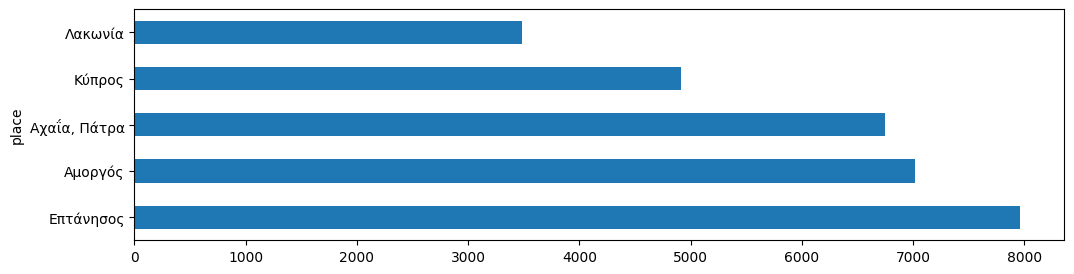

In [59]:
proverbs_sp.place.value_counts()[:5].plot.barh(figsize=(12,3));

* Let's visualise the places along with the number of proverbs collected there.

In [60]:
freq_places = proverbs_sp.place.value_counts()[:20]
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for i in range(10):
    freq = freq_places.iloc[i]
    place = freq_places.index[i].split(",")[0]
    loc = geolocs[place]
    folium.CircleMarker((loc["lat"], loc["lon"]), 
                  radius=freq/500,
                  popup=f"{freq}",
                  color="#3186cc",
                  fill=True,
                  fill_color="#3186cc").add_to(m)
m.save('frequent_places.html')
m

* Next, we'll work with those with 1,000 or more proverbs, allowing sampling without class imbalance issues.

In [61]:
group_level = "area"
placed = proverbs_sp.groupby(group_level)
placed_pd = pd.DataFrame({"text": placed.text.apply(list)})
placed_pd["length"] = placed_pd.text.apply(len)
print(f"Out of the {placed_pd.shape[0]} places, {placed_pd[placed_pd.length>1000].shape[0]} own 1000 proverbs or more.")

Out of the 129 places, 23 own 1000 proverbs or more.


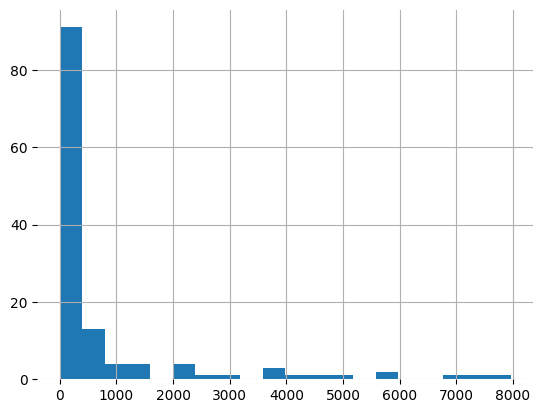

In [62]:
placed_pd.length.hist(bins=20);
sns.despine(left=True, bottom=True)

* The proverbs from places reported at least 1,000 times are more than 80,000.

In [63]:
common_places = placed_pd[placed_pd.length>=1000].index
# filtering texts found on these places
common_sayings = proverbs_sp[proverbs_sp[group_level].isin(common_places)]
print(f"Found {common_sayings.shape[0]} proverbs from {len(common_places)} places")

Found 80893 proverbs from 23 places


* We'll remove proverbs with unknown (invalid?) characters.

In [64]:
stopchars = {'$', '*', '+', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'G', 'H', 'I', 'N', 'O', 'P', 'S', 'T', 'W', '[', ']', 'a','b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'y', 'z', 'ä', '\ufeff'}
common_sayings_norm = common_sayings[~common_sayings.text.apply(lambda x: len(set(x).intersection(stopchars))>0)]

* We create a location-balanced corpus.

In [65]:
balanced_corpus = pd.concat([common_sayings_norm[common_sayings_norm.area==a].sample(500) for a in common_places])
balanced_corpus.shape

(11500, 7)

## Location-based TF * IDF
* For each place, we compute character n-gram frequencies (TF).
* Terms infrequent across all places are more important (IDF). 

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [68]:
long_texts = [" \n ".join(balanced_corpus[balanced_corpus.area==a].text.values) for a in common_places]
vect = TfidfVectorizer(ngram_range=(2,5), analyzer="char", max_df=0.5, min_df=5, lowercase=True)
X = vect.fit_transform(long_texts)

In [69]:
# computing the TFIDF per place
geotfidf = pd.DataFrame(columns = common_places, index=vect.get_feature_names_out())
for i, a in enumerate(common_places):
    geotfidf[a] = np.array(X[i].sum(0))[0]

* Sorting the frequencies per place, gives characteristic n-grams; i.e., frequent locally yet infrequent globally.

In [47]:
geotfidf.sort_values(by="Κύπρος", ascending=False).head(3)

area,Ήπειρος,Αιτωλία,Αμοργός,Ανατολική Θράκη,Αρκαδία,Αχαΐα,Επτάνησος,Εύβοια,Θεσπρωτία,Θράκη,...,Κρήτη,Κύπρος,Λέσβος,Λακωνία,Μακεδονία,Μικρά Ασία,Νάξος,Πόντος,Ρόδος,Σκύρος
τζ',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007289,0.343664,0.0,0.0,0.0,0.018494,0.008317,0.000000,0.0,0.005003
τζ',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007289,0.336504,0.0,0.0,0.0,0.018494,0.008317,0.000000,0.0,0.000000
τζ',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.006410,0.308530,0.0,0.0,0.0,0.016264,0.007314,0.005902,0.0,0.004400


* Computing a lexicon with the terms with the highest TFIDF value per area

In [48]:
area_ngrams = {a:list(geotfidf.sort_values(by=a, ascending=False)[a].head(3).index) for a in common_places}

* Locating the important terms on the map

In [49]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for a in area_ngrams:
    ngrams = ", ".join(area_ngrams[a])
    loc = geolocs[a]
    folium.Circle([loc["lat"], loc["lon"]], 20000, fill=True).add_child(folium.Popup(ngrams)).add_to(m)
m.save('frequent_ngrams.html'); m

In [50]:
geotfidf.to_csv("geotfidf.csv")

In [51]:
pd.DataFrame(area_ngrams)

,Ήπειρος,Αιτωλία,Αμοργός,Ανατολική Θράκη,Αρκαδία,Αχαΐα,Επτάνησος,Εύβοια,Θεσπρωτία,Θράκη,...,Κρήτη,Κύπρος,Λέσβος,Λακωνία,Μακεδονία,Μικρά Ασία,Νάξος,Πόντος,Ρόδος,Σκύρος
0,ου,ου,μεν,πάγ,ύρες,ου!,ναν,τσαί,ο),πε,...,ντου,τζ',τσι,ςτ,ου,κη,'ι,'ς σ,θθ,τσαί
1,είνε,τουν,μηδ,άγη,ύρες,ου!,ναν,σαί,ο),πε τ,...,ντου,τζ',τουν,ςτ,'πο,τουν,εώ,ας σ,(μ,τσαί
2,είνε,μι,μηδ,πάγ,έμου,υ!,είν,τσαί,(τ,ήρτ,...,ντο,τζ',' τσ,ςτο,'πο,λιν,τζη,άτ,κάμν,σαί


# Authorship analysis
* Training one language model per area, by sampling proverbs of that area



In [52]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(balanced_corpus, test_size=0.05, random_state=2023)
train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)

In [55]:
# INFO: robustness at stake
# !git clone https://github.com/ipavlopoulos/lm
from lm.markov.models import LM

models = {}
for area in train.area.unique():
    texts = train[train.area==area].text.values
    models[area] = LM(gram="CHAR").train(" \n ".join(texts))
    
def ling_dist(proverb, models=models):
    entropy = {loc:[models[loc].cross_entropy(proverb)] for loc in models.keys()}
    likelier = min(entropy, key=entropy.get) 
    return likelier, pd.DataFrame(entropy)

loc, dists = ling_dist('κακό χωριό τα λίγα σπίτια')
dists.sort_values(by=0, ascending=True, axis=1)

,Επτάνησος,Ήπειρος,Ανατολική Θράκη,Λακωνία,Αιτωλία,Κεφαλληνία,Θεσπρωτία,Εύβοια,Ρόδος,Θράκη,...,Ιωάννινα,Αχαΐα,Αμοργός,Αρκαδία,Κάρπαθος,Πόντος,Σκύρος,Μικρά Ασία,Λέσβος,Κύπρος
0,3.328618,3.617514,3.683254,3.767748,3.80619,3.940942,3.981729,4.071311,4.110943,4.191568,...,4.493212,4.590854,4.756299,4.888742,5.175772,5.255941,5.408235,5.424513,5.493353,5.755591


Ηύρες το σύκον σήκωσ' το, γιατί σηκώννει το άλλος (Κύπρος) -- predicted as: Κύπρος


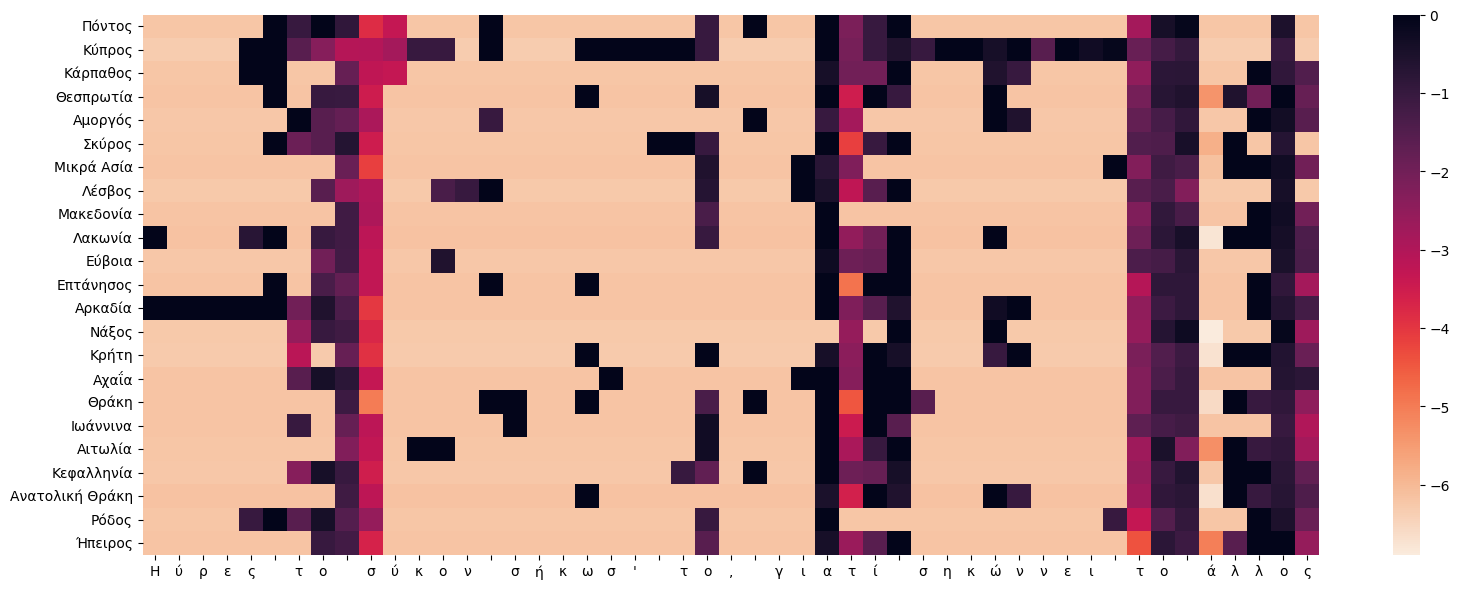

In [57]:
logprob = lambda txt, mdl: list(map(np.log2, mdl.compute_gram_probs(txt)))

def heatmap(txt, models):    
    plt.rcParams["figure.figsize"] = (len(txt)/3,6); plt.rcParams["axes.labelsize"] = 23;
    probs = {loc: logprob(txt, models[loc]) for loc in models.keys()}
    df = pd.DataFrame(probs, index=[str(c) for c in txt])
    return df, sns.heatmap(df.transpose(), cmap="rocket_r")

t = test[test.area=="Κύπρος"].sample().iloc[0]
df, ax = heatmap(t.text, models)
print(f'{t.text} ({t.area})', end=' -- ')
print(f'predicted as: {df.columns[df.mean(0).argmax()]}')
ax.figure.tight_layout()
ax.figure.savefig("heatmap.pdf", format="PDF", dpi=300)

* Evaluating on unseen proverbs

In [58]:
from sklearn.metrics import *
predictions = test.text.apply(lambda x: ling_dist(x, models=models)[0])
print(classification_report(test.area.values, predictions, zero_division=0))

                 precision    recall  f1-score   support

        Ήπειρος       0.00      0.00      0.00        23
        Αιτωλία       0.33      0.29      0.31        24
        Αμοργός       0.19      0.23      0.20        22
Ανατολική Θράκη       0.15      0.17      0.16        24
        Αρκαδία       0.24      0.16      0.19        31
          Αχαΐα       0.17      0.16      0.16        32
      Επτάνησος       0.16      0.17      0.17        23
         Εύβοια       0.10      0.20      0.14        20
      Θεσπρωτία       0.14      0.18      0.16        22
          Θράκη       0.15      0.12      0.13        25
       Ιωάννινα       0.09      0.07      0.08        29
       Κάρπαθος       0.34      0.36      0.35        28
     Κεφαλληνία       0.19      0.22      0.21        27
          Κρήτη       0.17      0.17      0.17        30
         Κύπρος       0.68      0.62      0.65        24
         Λέσβος       0.33      0.25      0.29        24
        Λακωνία       0.00    

* The confusion matrix can inform us about the confusion in the predictions

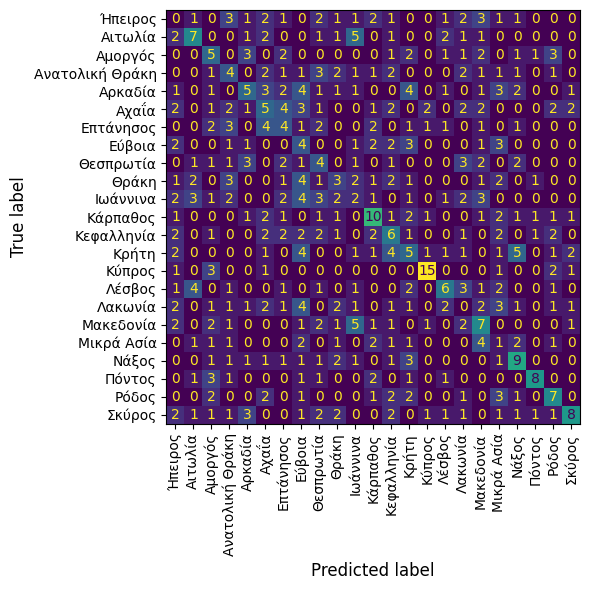

In [59]:
plt.rcParams["figure.figsize"] = (6,6); plt.rcParams["axes.labelsize"] = 12;
cm = ConfusionMatrixDisplay.from_predictions(test.area.values, predictions, xticks_rotation='vertical', colorbar=False);
cm.figure_.tight_layout(); cm.figure_.savefig('authorship_confusion.pdf', format="PDF", dpi=300)

# Text spatial classification
* Trying with a standard text classifier improves slightly the accuracy but similar findings are reported

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier

Learning a location classifier on top of character n-grams

In [61]:
# text classification with KNN
vect = TfidfVectorizer(ngram_range=(2,5), analyzer="char", max_df=0.5, min_df=5, lowercase=True)
locator = Pipeline([('vect', vect), ('clf', KNeighborsClassifier())])
locator.fit(train.text.values, train.area.values)
txt_preds = locator.predict(test.text.values)
print(classification_report(test.area.values, txt_preds, zero_division=0))

                 precision    recall  f1-score   support

        Ήπειρος       0.05      0.17      0.08        23
        Αιτωλία       0.14      0.29      0.19        24
        Αμοργός       0.06      0.18      0.09        22
Ανατολική Θράκη       0.03      0.08      0.05        24
        Αρκαδία       0.14      0.19      0.16        31
          Αχαΐα       0.23      0.16      0.19        32
      Επτάνησος       0.10      0.09      0.09        23
         Εύβοια       0.11      0.15      0.12        20
      Θεσπρωτία       0.03      0.05      0.04        22
          Θράκη       0.00      0.00      0.00        25
       Ιωάννινα       0.14      0.10      0.12        29
       Κάρπαθος       0.40      0.29      0.33        28
     Κεφαλληνία       0.07      0.04      0.05        27
          Κρήτη       0.22      0.07      0.10        30
         Κύπρος       0.71      0.42      0.53        24
         Λέσβος       0.11      0.04      0.06        24
        Λακωνία       0.00    

In [62]:
# text classification with Forest
vect = TfidfVectorizer(ngram_range=(2,5), analyzer="char", max_df=0.5, min_df=5, lowercase=True)
locator = Pipeline([('vect', vect), ('clf', RandomForestClassifier())])
locator.fit(train.text.values, train.area.values)
txt_preds = locator.predict(test.text.values)
print(classification_report(test.area.values, txt_preds, zero_division=0))

                 precision    recall  f1-score   support

        Ήπειρος       0.05      0.04      0.05        23
        Αιτωλία       0.27      0.50      0.35        24
        Αμοργός       0.16      0.23      0.19        22
Ανατολική Θράκη       0.11      0.17      0.13        24
        Αρκαδία       0.32      0.26      0.29        31
          Αχαΐα       0.38      0.34      0.36        32
      Επτάνησος       0.15      0.17      0.16        23
         Εύβοια       0.21      0.15      0.18        20
      Θεσπρωτία       0.11      0.09      0.10        22
          Θράκη       0.00      0.00      0.00        25
       Ιωάννινα       0.10      0.10      0.10        29
       Κάρπαθος       0.62      0.46      0.53        28
     Κεφαλληνία       0.22      0.22      0.22        27
          Κρήτη       0.33      0.23      0.27        30
         Κύπρος       0.58      0.75      0.65        24
         Λέσβος       0.26      0.25      0.26        24
        Λακωνία       0.19    

# Classifying multi-located proverbs

* Such a classifier can give an estimate about the origins of proverbs multiply located  

In [63]:
duplicated_predicted_pd = duplicates[duplicates.area_num>1]
duplicated_predicted_pd.insert(4, "prediction", locator.predict(duplicated_predicted_pd.index.values))
probs = locator.predict_proba(duplicated_predicted_pd.index.values)
duplicated_predicted_pd.insert(5, "confidence", probs.max(1))
# duplicated_predicted_pd.reset_index().to_excel("sayings_duplicated_located.xlsx", index=False)
duplicated_predicted_pd.sort_values(by="confidence", ascending=False).head(20)

,place,place_num,area,area_num,prediction,confidence,latlon
text,,,,,,,
"Ξάστερος ουρανός, αστραπές δε φοβάται","{Θράκη, Σωζόπολη, Ανατολική Θράκη}",2,"{Θράκη, Ανατολική Θράκη}",2,Κεφαλληνία,0.74,"[(40.8464241, 25.8759377), (41.6759327, 26.558..."
Μπίρι σου και μπίρι μου,"{Αμοργός, Σύρος}",2,"{Αμοργός, Σύρος}",2,Αμοργός,0.74,"[(36.85252415, 25.89848696771565), (37.4385100..."
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Αδριανούπολη, Τήλος, Μακεδονία, Σισάνι, Λιμπό...",28,"{Αχαΐα, Αδριανούπολη, Κοζάνη, Τήλος, Νάξος, Χί...",18,Εύβοια,0.73,"[(38.0692748, 21.87273042232539), (41.6759327,..."
"Ξένο ψωμί, δικό του μαχαίρι","{Μικρά Ασία, Βιθυνία, Σιγή, Κρήτη, Κυδωνία, Αν...",3,"{Κρήτη, Μικρά Ασία, Ανατολική Θράκη}",3,Κρήτη,0.72,"[(35.3084952, 24.46334231842296), (38.1846366,..."
Αλλού τα κακαρίσματα κι' αλλού γεννάν οι κόττες,"{Αχαΐα, Πάτρα, Κεφαλληνία, Ήπειρος}",3,"{Αχαΐα, Κεφαλληνία, Ήπειρος}",3,Ιωάννινα,0.71,"[(38.0692748, 21.87273042232539), (38.2379344,..."
Άλλοι σπέρνουν και θερίζουν κι' άλλοι τρων και μαγαρίζουν,"{Αδριανούπολη, Ρόδος, Αρκαδία, Γορτυνία}",3,"{Αδριανούπολη, Αρκαδία, Ρόδος}",3,Κρήτη,0.71,"[(41.6759327, 26.5587225), (38.0368583, 23.668..."
"Ανεμομαζώματα, διαολοσκορπίσματα","{Κρήτη, Σητεία, Σκοπή, Θεσσαλία, Τρίκαλα, Κρήτ...",7,"{Νάξος, Κρήτη, Αιτωλοακαρνανία, Κύπρος, Θεσσαλ...",6,Εύβοια,0.70,"[(37.06001045, 25.47075670857837), (35.3084952..."
Ή του ύψους ή του βάθους,"{Χίος, Μικρά Ασία, Σινώπη, Μήλος, Νάξος, Απείρ...",5,"{Νάξος, Χίος, Μήλος, Μικρά Ασία, Ήπειρος}",5,Μικρά Ασία,0.69,"[(37.06001045, 25.47075670857837), (38.3758131..."
Όποιος ανακατεύεται με τα πίτουρα τον τρων οι κότες,"{Ιωάννινα, Μέγα Περιστέρι, Θεσπρωτία, Παραμυθι...",3,"{Εύβοια, Θεσπρωτία, Ιωάννινα}",3,Θεσπρωτία,0.69,"[(38.49417235, 23.91108439913793), (39.5440123..."


# Regression on the coordinates
* Instead of classifying the place, we can learn to predict the geographical coordinates.
* By using linear regression, we can measure feature importance afterwards, n-grams which distinguish spatially, from South to North, from West to East. 

In [76]:
vect = TfidfVectorizer(ngram_range=(1,1), analyzer="word", max_df=0.5, min_df=5, lowercase=True)
linear = Pipeline([('vect', vect), ('reg', LinearRegression())])
linear.fit(train.text.values, train[["lat", "lon"]].values)
txt_preds = linear.predict(test.text.values)

* R2 is the coefficient of determination, measuring how well a statistical model predicts the model's dependent variable (the outcome).

In [77]:
print(f'R2 (train): {linear.score(train.text, train[["lat", "lon"]].values):.3f}')
print(f'R2 (dev): {linear.score(dev.text, dev[["lat", "lon"]].values):.3f}')

R2 (train): 0.401
R2 (dev): 0.133


In [78]:
predicted_coords = linear.predict(test.text.values)
print(f"MAE of lat and lon: {mean_absolute_error(test.lat.values, predicted_coords[:, 0]):.2f} & {mean_absolute_error(test.lon.values, predicted_coords[:, 1]):.2f}")
print(f"MSE of lat and lon: {mean_squared_error(test.lat.values, predicted_coords[:, 0]):.2f} & {mean_squared_error(test.lon.values, predicted_coords[:, 1]):.2f}")

MAE of lat and lon: 1.35 & 1.98
MSE of lat and lon: 2.87 & 6.54


* Another measure is accuracy, defined based on some threshold.
* For example, measuring the number of texts whose lat, lon, lat and lon, was predicted within some threshold (e.g., 0.5, 1, 1.5).  

In [79]:
acc = pd.DataFrame({"gold_lat": test.lat.values, "gold_lon": test.lon.values, 
                    "pred_lat": predicted_coords[:, 0], "pred_lon": predicted_coords[:, 1]})

legit_lat, legit_lon = [], []
thresholds = [t/10. for t in range(30)]
for th in thresholds: 
    legit_lat.append(100*acc[acc.apply(lambda row: abs(row.gold_lat-row.pred_lat)<th, 1)].shape[0]/acc.shape[0])
    legit_lon.append(100*acc[acc.apply(lambda row: abs(row.gold_lon-row.pred_lon)<th, 1)].shape[0]/acc.shape[0])

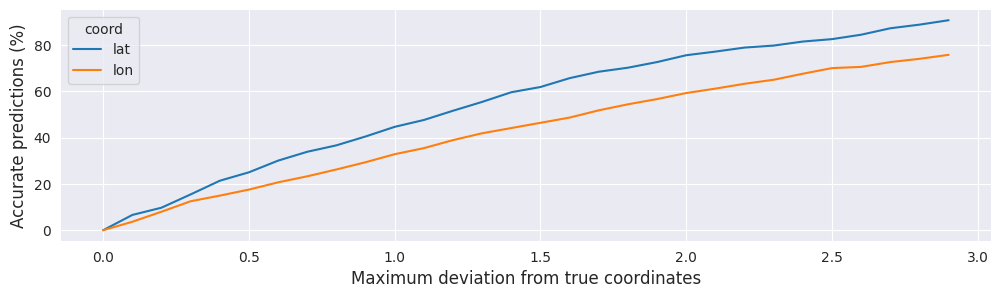

In [80]:
plt.rcParams["figure.figsize"] = (12,3)
d = pd.DataFrame({"accurate": legit_lat+legit_lon, 'threshold':thresholds+thresholds, 'coord':['lat']*len(thresholds)+['lon']*len(thresholds)})
ax = sns.lineplot(d, y="accurate", x="threshold", hue='coord')
ax.set(ylabel="Accurate predictions (%)", xlabel="Maximum deviation from true coordinates");
sns.set_style('darkgrid'); sns.despine(left=True, bottom=True)

In [81]:
importance_pd = pd.DataFrame({"feature":linear["vect"].get_feature_names_out(), 
                              "lat": linear["reg"].coef_[0, :],
                              "lon": linear["reg"].coef_[1, :]})

* n-grams pushing $\uparrow$ north (higher lat)


In [82]:
importance_pd.sort_values(by="lat", ascending=False).head(5)

,feature,lat,lon
151,αγουρίδα,4.936137,-0.600842
1199,πάγη,4.780721,2.057884
167,ακριβή,4.520245,-2.058107
1148,ξέν,4.514971,-2.621635
1152,ξένοι,4.494004,-5.240178


* n-grams pushing $\downarrow$ south (lower lat)


In [83]:
importance_pd.sort_values(by="lat", ascending=True).head(5)

,feature,lat,lon
1583,τζιαι,-5.781206,14.892781
1428,πόνοι,-5.570382,7.947929
1111,νέφη,-5.189237,10.871322
750,καλλιά,-4.944905,0.027422
1581,τζι,-4.053697,11.080305


* n-grams pushing $\rightarrow$ east (higher lon)


In [84]:
importance_pd.sort_values(by="lon", ascending=False).head(5)

,feature,lat,lon
1583,τζιαι,-5.781206,14.892781
1581,τζι,-4.053697,11.080305
1111,νέφη,-5.189237,10.871322
1579,τζαι,-3.733425,10.676900
1578,τζαί,-3.634034,9.717263


* n-grams pushing $\leftarrow$ west (lower lon)


In [87]:
importance_pd.sort_values(by="lon", ascending=True).head(5)

,feature,lat,lon
273,βαρβάρα,-2.488038,-9.470591
516,δούλεψε,0.902288,-7.697464
606,ζήση,1.096423,-7.614643
1527,σταφύλι,2.578737,-7.598335
245,αυτού,4.440578,-7.302593


# Proverb alteration

* We alread observed that duplicates exist, but near duplicates may also be present, due to spatial propagation.
* We investigate this hypothesis, by measuring the edit distance per proverb, using ones co-existing in many areas.

In [88]:
highly_distr = duplicates.sort_values(by='area_num', ascending=False).head(3)
highly_distr

,place,place_num,area,area_num,latlon
text,,,,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Κοζάνη, Βόϊο, Ανθούσα, Θεσπρωτία, Παραμυθιά, ...",45,"{Αχαΐα, Ανατολική Θράκη, Νίσυρος, Αρκαδία, Ρού...",23,"[(38.0692748, 21.87273042232539), (41.6759327,..."
Στου κουφού την πόρτα όσο θέλεις βρόντα,"{Θεσπρωτία, Παραμυθιά, Λακωνία, Ανατολική Θράκ...",26,"{Πέλλα, Λακωνία, Ανατολική Θράκη, Νίσυρος, Αρκ...",20,"[(40.7541229, 22.517832973183303), (36.7602794..."
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Αδριανούπολη, Τήλος, Μακεδονία, Σισάνι, Λιμπό...",28,"{Αχαΐα, Αδριανούπολη, Κοζάνη, Τήλος, Νάξος, Χί...",18,"[(38.0692748, 21.87273042232539), (41.6759327,..."


Measuring the edit distance between each of this and all other (non-duplicate) proverbs

In [ ]:
%%capture
!pip install python-Levenshtein

In [92]:
from Levenshtein import distance as lev
i = 0
target = highly_distr.reset_index().iloc[i].text
candidates = proverbs
candidates["lev"] = candidates.text.map(lambda x: lev(x, target))
near_duplicates = candidates[(candidates.lev<5)&((candidates.lev>0))]
near_duplicates

,text,place,uri,collector,area,lat,lon,lev
4879,Η γλώσσα κόκκαλα δεν έχι και κόκκαλα τσακίζ',"Θράκη, Σαράντα Εκκλησίες",http://hdl.handle.net/20.500.11853/169165,"Βαφείδης, Θεολόγης Γ.",Θράκη,40.846424,25.875938,3
8950,Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζει,"Μακεδονία, Βογατσικό",http://hdl.handle.net/20.500.11853/165301,"Γρέζος, Τριαντάφυλλος",Μακεδονία,40.686024,23.693434,2
12296,Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακά,Ρόδος,http://hdl.handle.net/20.500.11853/170697,"Δρακίδης, Γεράσιμος Δ.",Ρόδος,36.172630,27.919418,4
12297,Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακκά,Ρόδος,http://hdl.handle.net/20.500.11853/186599,"Δρακίδης, Γεράσιμος Δ.",Ρόδος,36.172630,27.919418,4
14088,Η γλώσσα κόκκαλα (δ)εν έχει και κόκκαλα τσακίζει,"Κως, Πυλί",http://hdl.handle.net/20.500.11853/179636,"Ζάρακας, Νικόλαος Α.",Κως,36.793693,27.084827,2
14089,Η γλώσσα κόκκαλα (δ)εν έχει και κόκκαλα τσακίζει,"Κως, Πυλί",http://hdl.handle.net/20.500.11853/195775,"Ζάρακας, Νικόλαος Α.",Κως,36.793693,27.084827,2
19761,Η γλώσσα κόκκαλα δεν έχει μα κόκκαλα τσακίζει,"Μακεδονία, Σισάνι, Λιμπόχοβο",http://hdl.handle.net/20.500.11853/172414,"Ιωαννίδης, Αθ.",Μακεδονία,40.686024,23.693434,2
28103,Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακεί,"Θράκη, Βιζύη",http://hdl.handle.net/20.500.11853/164735,"Ιωαννίδης, Σάββας",Θράκη,40.846424,25.875938,3
37378,Η γλώσσα κόκκαλα δεν έχει κόκκαλα τσακίζει,"Θράκη, Περιστερά",http://hdl.handle.net/20.500.11853/164689,"Καλλίας, Λάμπρος Γ.",Θράκη,40.846424,25.875938,4
54176,Γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,Αδριανούπολη,http://hdl.handle.net/20.500.11853/168157,"Κουρτίδης, Κωνσταντίνος Γ.",Αδριανούπολη,41.675933,26.558722,3


* Finding areas in the near duplicates but not in the (exact text) duplicates

In [93]:
set(near_duplicates.area.values) - highly_distr.reset_index().iloc[i].area

{'Αδριανούπολη', 'Κως', 'Μακεδονία', 'Νάουσα', 'Ρόδος', 'Σκύρος'}

In [94]:
i = 1
target = highly_distr.reset_index().iloc[i].text
candidates = proverbs
candidates["lev"] = candidates.text.map(lambda x: lev(x, target))
near_duplicates = candidates[(candidates.lev<5)&((candidates.lev>0))]
new_areas = set(near_duplicates.area.values) - highly_distr.reset_index().iloc[i].area
print(len(new_areas))
print(new_areas)
near_duplicates

19
{'Αχαΐα', 'Αδριανούπολη', 'Ηλεία', 'Χίος', 'Κάρπαθος', 'Αργολίδα', 'Εύβοια', 'Λέσβος', 'Κέρκυρα', 'Μακεδονία', 'Κως', 'Κορινθία', 'Μήλος', 'Μικρά Ασία', 'Ήπειρος', 'Σάμος', 'Δαρδανέλλια (Ελλήσποντος)', 'Κύπρος', 'Ρόδος'}


,text,place,uri,collector,area,lat,lon,lev
544,Σ του κουφού την πόρτα όσο θέλεις βρόντα,"Εύβοια, Κύμη",http://hdl.handle.net/20.500.11853/273878,"Αλεξανδρής, Απόστολος",Εύβοια,38.494172,23.911084,1
4730,Σ του κουφού την πόρτα όσο θέλεις βρόντα,Δαρδανέλλια (Ελλήσποντος),http://hdl.handle.net/20.500.11853/273384,"Βασιλειάδης, Κωνσταντίνος Ε.",Δαρδανέλλια (Ελλήσποντος),40.337606,26.640821,1
6886,"Στου κουφού την πόρτα, όσο θέλεις βρόντα",Άνδρος,http://hdl.handle.net/20.500.11853/232019,"Βογιατζίδης, Ι. Κ.",Άνδρος,37.840835,24.862382,1
7261,"Στου κουφού τη πόρτα, όσο θέλεις βρόντα","Κοζάνη, Βόϊο, Γαλατινή",http://hdl.handle.net/20.500.11853/274573,"Βουζιανάς, Κωνσταντίνος",Κοζάνη,40.300726,21.788312,2
9704,Στου κουφού την μπόρτα όσο θέλς βρόντα,"Θράκη, Αυδήμιο",http://hdl.handle.net/20.500.11853/227671,"Δεληγιάννης, Βασίλης",Θράκη,40.846424,25.875938,3
9867,Τού κουφού την πόρτα όσο θέλεις βρόντα,Ρούμελη,http://hdl.handle.net/20.500.11853/274346,"Δελούση, Αθανασία Γ.",Ρούμελη,35.404968,24.700103,3
10434,Σ του κουφού την πόρτα όσο θέλεις βρόντα,"Θράκη, Σηλυβρία",http://hdl.handle.net/20.500.11853/273263,"Δημοσθενόπουλος, Σωσίπατρος",Θράκη,40.846424,25.875938,1
13200,"Στου κουφού τη πόρτα, όσο θέλεις βρόντα",Ρόδος,http://hdl.handle.net/20.500.11853/228427,"Δρακίδης, Γεράσιμος Δ.",Ρόδος,36.172630,27.919418,2
13201,Στου κουφού τημ πόρτα όσο θέλης βρόντα,Ρόδος,http://hdl.handle.net/20.500.11853/273746,"Δρακίδης, Γεράσιμος Δ.",Ρόδος,36.172630,27.919418,3
13801,Στου κουφού την πόρταν όσον θέλεις βρόντα,Κύπρος,http://hdl.handle.net/20.500.11853/273544,"Ερωτόκριτος, Ιωάννης",Κύπρος,34.982302,33.145128,2


In [95]:
i = 2
target = highly_distr.reset_index().iloc[i].text
candidates = proverbs
candidates["lev"] = candidates.text.map(lambda x: lev(x, target))
near_duplicates = candidates[(candidates.lev<5)&((candidates.lev>0))]
new_areas = set(near_duplicates.area.values) - highly_distr.reset_index().iloc[i].area
print(len(new_areas))
print(new_areas)
near_duplicates.sort_values("lev", ascending=False).head(20)

17
{'Σάμος', 'Ιωάννινα', 'Λακωνία', 'Ανατολική Θράκη', 'Νίσυρος', 'Βοιωτία', 'Κεφαλληνία', 'Θεσπρωτία', 'Αιτωλοακαρνανία', 'Σκύρος', 'Ημαθία', 'Ρούμελη', 'Κύπρος', 'Θεσσαλία', 'Ρόδος', 'Επτάνησος', 'Φιλιππούπολη'}


,text,place,uri,collector,area,lat,lon,lev
79527,Ανεμουμαζώματα διαβοσκορπίσματα,"Μικρά Ασία, Λιβίσσι (Λειβίσσι)",http://hdl.handle.net/20.500.11853/153830,Μουσαίος,Μικρά Ασία,38.184637,23.512277,4
94119,"Ανεμομαζώματα, δαιμονοσκορπίσματα","Κρήτη, Σητεία",http://hdl.handle.net/20.500.11853/189090,"Παπαδάκη, Ειρήνη",Κρήτη,35.308495,24.463342,4
98218,Ανεμομαζώματα διαβουλουσκουρπίσματα,Αδριανούπολη,http://hdl.handle.net/20.500.11853/196946,"Παπαχριστοδούλου, Πολύδωρος",Αδριανούπολη,41.675933,26.558722,4
100770,"Ανεμομαζώματα, δαιμονοσκορπίσματα",Σκύρος,http://hdl.handle.net/20.500.11853/195161,"Περδίκα, Νίκη Λ.",Σκύρος,38.873044,24.524477,4
62444,Ανιμουμαζώματα διαβουλοσκορπίσματα,Αδριανούπολη,http://hdl.handle.net/20.500.11853/186040,"Λαμπουσιάδης, Γεώργιος Ι.",Αδριανούπολη,41.675933,26.558722,4
56358,"Ανεμομαζώματα, δαιμονοσκορπίσματα",Κύπρος,http://hdl.handle.net/20.500.11853/194481,"Κυριαζής, Νίκος Γ.",Κύπρος,34.982302,33.145128,4
11947,Ανεμομαδέματα διαολοσκορπίσματα,Ρόδος,http://hdl.handle.net/20.500.11853/142563,"Δρακίδης, Γεράσιμος Δ.",Ρόδος,36.172630,27.919418,4
41532,"Ανεμομαζώματα, δαιμοοσκορπίσματα",Ιωάννινα,http://hdl.handle.net/20.500.11853/147957,"Κατζιούλης, Παρθένιος",Ιωάννινα,39.663982,20.852278,4
36061,"Ανεμομαζέματα, δια(β)ολοσκορπίσματα",Νίσυρος,http://hdl.handle.net/20.500.11853/186837,"Καζαβής, Γεώργιος Ν.",Νίσυρος,36.589046,27.169184,3
98217,"Ανεμομάζωματα, διαολοσκορπίσματα","Θράκη, Σαράντα Εκκλησίες",http://hdl.handle.net/20.500.11853/197065,"Παπαχριστοδούλου, Πολύδωρος",Θράκη,40.846424,25.875938,3


# Agglomerative clustering

* Besides duplicate proverbs, near-duplicates also exist, probably due to the spatial propagation of proverbs over time. 
* We employ linguistic distance to estimate the route of a proverb, assuming that shorter travels lead to fewer edits.   


```
input: proverb target, threshold e
output: the target's dendrogram
1. for proverb in proverbs:
2.   dist[proverb] = edit_distance(proverb, target)
3. sort(dist, ascending=True)
4. filtered = [p in dist if dist[p]<e] 
5. representations = TFIDF(filtered)
6. dendrogram = Ward(representations)
```

* Exploring the three targets discussed above.
* Fetching versions up to a given linguistic distance compared to our target
* Using edit distance, we consider proverbs with few edits as candidate paraphrases of our target

In [96]:
target = highly_distr.reset_index().iloc[1].text.lower()

* Fetching proverbs up to a given linguistic distance compared to our target
* Using edit distance, we consider proverbs with few edits as candidate paraphrases of our target

In [97]:
from Levenshtein import distance as lev
candidates = proverbs
candidates["lev"] = candidates.text.map(lambda x: lev(x, target))

In [98]:
close_candidates = candidates[candidates.lev < 20]
close_candidates.sample(5)

,text,place,uri,collector,area,lat,lon,lev
109128,Σ' τού κουφού τη πόρτα όσο θέλεις βρόντα,"Κορινθία, Τρίκαλα",http://hdl.handle.net/20.500.11853/273607,"Σταματούλης, Ι. Π.",Κορινθία,37.962991,22.733342,5
13801,Στου κουφού την πόρταν όσον θέλεις βρόντα,Κύπρος,http://hdl.handle.net/20.500.11853/273544,"Ερωτόκριτος, Ιωάννης",Κύπρος,34.982302,33.145128,3
80641,Στου κουφού την πόρτα όσο θέλεις βρόντα,"Καστοριά, Απόσκεπος",http://hdl.handle.net/20.500.11853/272951,"Μπακάλης, Ιωάννης",Καστοριά,40.521795,21.263495,1
28009,"Στου κουφού την πόρτα, όσο θέλεις βρόντα","Θεσπρωτία, Κωστάνα",http://hdl.handle.net/20.500.11853/274598,"Ιωαννίδης, Κωνσταντίνος Θ.",Θεσπρωτία,39.544012,20.308355,2
13201,Στου κουφού τημ πόρτα όσο θέλης βρόντα,Ρόδος,http://hdl.handle.net/20.500.11853/273746,"Δρακίδης, Γεράσιμος Δ.",Ρόδος,36.172630,27.919418,4


* Hierarchically clustering the candidate versions of our target proverb
* Employing single linkage, using the minimum distance between the proverbs of two clusters as a criterion for merging.
* Based on the assumption that the fewer edits reflect the chosen route.  

In [99]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

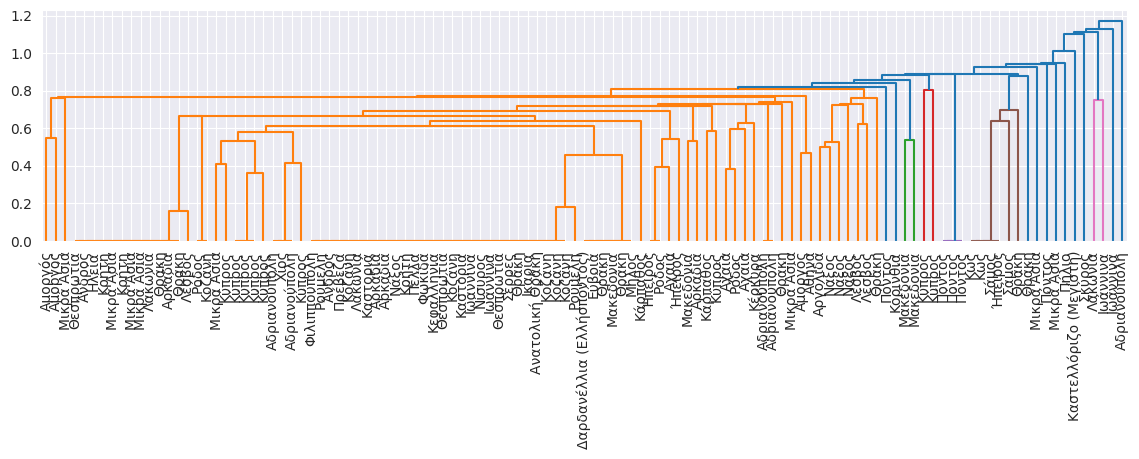

In [100]:
vec = TfidfVectorizer(analyzer="char", ngram_range=(2,5), lowercase=True, strip_accents="unicode")
X = vec.fit_transform(close_candidates.text.values)
Z = linkage(X.toarray(), 'single')
fig = plt.figure(figsize=(14, 3))
ax = dendrogram(Z, orientation='top', labels=close_candidates.area.values, distance_sort='descending', show_leaf_counts=False, leaf_font_size=10., show_contracted=True);
fig.savefig('deaf_man_door.pdf', format="PDF", dpi=300)

* To better understand the clustering, we create a dataframe and filter based on distance

In [101]:
clustering = fcluster(Z, t=0.4, criterion='distance')
close_candidates.insert(6, "clustering", clustering)
#close_candidates["clustering"] = clustering
grouped = close_candidates.groupby("clustering")
clusters = pd.DataFrame({"cluster":grouped.area.apply(list), "text":grouped.text.apply(list)})
clusters[clusters.cluster.apply(len)>1]

,cluster,text
clustering,,
3,"[Κως, Κως, Σάμος, Ήπειρος]","[Στου κουφού τη μπόρτα όσο θέλεις βρόντα, Στου..."
7,"[Πόντος, Πόντος, Πόντος]","[Σ ση κωφού τημ πόρταν όσον θέλεις βρόντα, Σ σ..."
21,"[Αδριανούπολη, Αδριανούπολη]","[Σ του κουφού την πόρτα όσον θέλ'ς βρόντα, Σ τ..."
22,"[Ρόδος, Αχαΐα]","[Στου κουφού τημ πόρτα όσο θέλης βρόντα, Στου ..."
29,"[Ρόδος, Αχαΐα, Ήπειρος]","[Στου κουφού τημ πόρτα όσο θέλεις βρόντα, Σ το..."
31,"[Εύβοια, Δαρδανέλλια (Ελλήσποντος), Θράκη, Μακ...","[Σ του κουφού την πόρτα όσο θέλεις βρόντα, Σ τ..."
32,"[Ρούμελη, Φιλιππούπολη, Άνδρος, Πρέβεζα, Κοζάν...","[Στου κουφού την πόρτα όσο θέλεις βρόντα, Στου..."
33,"[Χίος, Αδριανούπολη, Αδριανούπολη]","[Σ του κουφού την πόρτα όσον θέλεις βρόντα, Σ ..."
35,"[Κύπρος, Κύπρος, Κύπρος, Κύπρος]","[Στου κουφού την πόρταν όσον θέλεις βρόντα, Σ ..."


In [102]:
# focus on clusters with more than one area
for i, row in clusters[clusters.cluster.apply(len)>1].iterrows():
    # hash to avoid duplicated areas (neighbouring proverbs)
    d = dict(list(zip(row.cluster, row.text)))
    if len(d)>1: # ignore duplicates
        # print the clustered versions  
        for place in d:
            print(f'{place} --> {d[place]}')
        print()

Κως --> Στου κουφού τη μπόρτα όσο θέλεις βρόντα
Σάμος --> Στου κουφού τη μπόρτα όσο θελεις βρόντα
Ήπειρος --> Στου κουφού τη μπόρτα όσο θέλεις βρόντα

Ρόδος --> Στου κουφού τημ πόρτα όσο θέλης βρόντα
Αχαΐα --> Στου κουφού τημ πόρτα όσο θέλης βρόντα!

Ρόδος --> Στου κουφού τημ πόρτα όσο θέλεις βρόντα
Αχαΐα --> Σ του κουφού τημ πόρτα όσο θέλεις βρόντα
Ήπειρος --> Στου κουφού τημ πόρτα όσο θέλεις βρόντα

Εύβοια --> Σ του κουφού την πόρτα όσο θέλεις βρόντα
Δαρδανέλλια (Ελλήσποντος) --> Σ του κουφού την πόρτα όσο θέλεις βρόντα
Θράκη --> Σ του κουφού την πόρτα όσο θέλεις βρόντα
Μακεδονία --> Σ του κουφού την πόρτα όσο θέλεις βρόντα
Μήλος --> Σ του κουφού την πόρτα όσο θέλεις βρόντα

Ρούμελη --> Τού κουφού την πόρτα όσο θέλεις βρόντα
Φιλιππούπολη --> Στου κουφού την πόρτα όσο θέλεις βρόντα
Άνδρος --> Στου κουφού την πόρτα όσο θέλεις βρόντα
Πρέβεζα --> Στου κουφού την πόρτα όσο θέλεις βρόντα
Κοζάνη --> Στου κουφού την πόρτα όσο θέλεις βρόντα
Λακωνία --> Στου κουφού την πόρτα όσο θέλεις βρόντα


# Proverb propagation
Focusing on the duplicates, which we know they have already travelled.

### A synthetic example
* Ιntroducing location-based noise sources, e.g., by adding a nasal (Cyrpus) or /k/>/ts/ (Crete).
* Then, altering proverbs by visiting virtually an area directly (adding noise of one type) or through other areas (adding multiple noises).

In [106]:
def nasal(txt):
    out = []
    for word in txt.split():
        out.append(word+"ν" if word[-1] in {"ε","ο","η","α"} else word)
    return " ".join(out)
    
def tsita(txt):
    return txt.replace("κ", "τσ")

source = "η παροιμία για τη παροιμία και τη παράδοση"
cyprus = nasal(source)
crete = tsita(source)
route = nasal(tsita(source))

print(f'{route}\t: (Source>Crete>Cyrpus: {lev(source, route)} edits)')
print(f'{cyprus}\t (Source>Crete: {lev(source, crete)} edits)')
print(f'{crete}\t (Crete>Cyprus: {lev(crete, route)} edits)')

ην παροιμίαν γιαν την παροιμίαν τσαι την παράδοσην	: (Source>Crete>Cyrpus: 9 edits)
ην παροιμίαν γιαν την παροιμίαν και την παράδοσην	 (Source>Crete: 2 edits)
η παροιμία για τη παροιμία τσαι τη παράδοση	 (Crete>Cyprus: 7 edits)


* There is a path (Source > Crete > Cyprus) whose sum of edit distances equals the distance between the two edges (Source - Cyprus) 

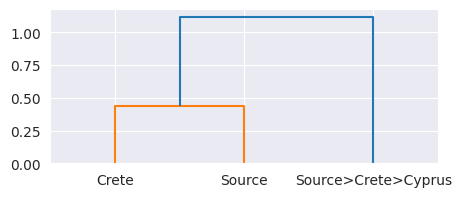

In [108]:
vec = TfidfVectorizer(analyzer="char", ngram_range=(2,5), lowercase=True, strip_accents="unicode")
X = vec.fit_transform([source, tsita(source), nasal(tsita(source))])
Z = linkage(X.toarray(), 'single')
fig = plt.figure(figsize=(5, 2))
ax = dendrogram(Z, orientation='top', labels=["Source", "Crete", "Source>Crete>Cyprus"], distance_sort='descending', show_leaf_counts=False, leaf_font_size=10., show_contracted=True);

* The Source proveb is near the Source>Cretan alteration (orange cluster)
* Which is near the Source>Cretan>Cypriotic alteration (blue link) 

### Revealing routes
Focusing on one with many near-duplicates, hence the likelihood of travelling being high.

In [110]:
# computing the distance between the source and any target
distances = {a:{} for a in close_candidates.area.unique()}
for i, (t1,a1) in enumerate(close_candidates[["text", "area"]].values):
    for j, (t2,a2) in enumerate(close_candidates[["text", "area"]].values):
        if i<j:
            dist = lev(t1,t2)
            if a2 in distances[a1]:
                if dist > distances[a1][a2]:
                    continue
            distances[a1][a2] = dist

In [111]:
# finding the shortest path